# Stability of the Grid System

Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy sources, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable using the UCI Electrical Grid Stability Simulated dataset.

## About Dataset
Dataset source: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

It has 12 primary predictive features and two dependent variables.

##### Predictive features:

- 'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
- 'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
- 'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');

##### Dependent variables:

- 'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
- 'stabf': a categorical (binary) label ('stable' or 'unstable').

### Preliminary Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale = 1.3)
%matplotlib inline

In [2]:
df = pd.read_csv('Data_for_UCI_named.csv')
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [3]:
# ''' Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise),
# 'stab' should be dropped and 'stabf' will remain as the sole dependent variable (binary classification).**'''
df = df.drop(['stab'], axis=1)
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable


### Exploratory Data Analysis
> Here we would explore the dataset for insights and also check if the dataset requires cleaning.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stabf   10000 non-null  object 
dtypes: float64(12), object(1)
memory usage: 1015.8+ KB


In [5]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930


#### Visualizing Numerical Columns

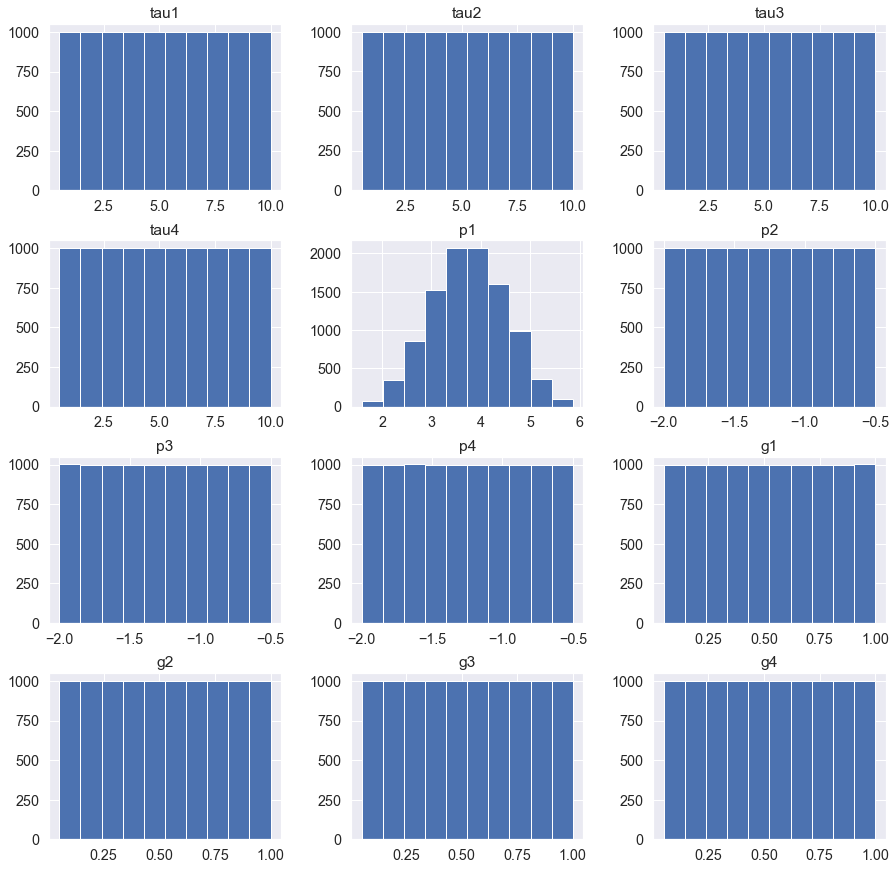

In [6]:
sns.set(font_scale = 1.3)
df.hist(figsize = (15, 15));

#### RESULTS OF EDA:
The dataset is clean, with all features in the right datatype, no null values etc.

## Model Building

##### Import necessary libraries

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, classification_report

##### Split the data into features(X) and Target(Y)

In [8]:
x = df.drop(['stabf'], axis=1)
y = df['stabf']
x.head(1)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.95906,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034


In [9]:
y.head(3)

0    unstable
1      stable
2    unstable
Name: stabf, dtype: object

##### Change 'stabf' to binary(1, 0)
> 0 = unstable, 1 = stable

In [10]:
y = y.replace({'unstable':0, 'stable':1})
y.head(3)

0    0
1    1
2    0
Name: stabf, dtype: int64

##### Split the data into Training and Testing set

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

### Random Forest Classifier

In [12]:
# Instantiate model
rf = RandomForestClassifier(random_state = 1)

# Fit on training set
rf.fit(x_train, y_train)

# Make Predict
y_pred = rf.predict(x_test)

rf_acc = accuracy_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

# classification repoert
print(classification_report(y_test, y_pred))
print('accuracy score:', rf_acc)
print('f1 score:', rf_f1)
print('r2 score:', rf_r2)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1288
           1       0.93      0.87      0.90       712

    accuracy                           0.93      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.93      0.93      2000

accuracy score: 0.9295
f1 score: 0.8980477223427332
r2 score: 0.6924942424453906


### Extra Trees Classifier

In [13]:
# Instantiate model
ext = ExtraTreesClassifier(random_state = 1)

# Fit on training set
ext.fit(x_train, y_train)

# Make Predict
y_pred = ext.predict(x_test)

ext_acc = accuracy_score(y_test, y_pred)
ext_f1 = f1_score(y_test, y_pred)
ext_r2 = r2_score(y_test, y_pred)

# classification repoert
print(classification_report(y_test, y_pred))
print('accuracy score:', ext_acc)
print('f1 score:', ext_f1)
print('r2 score:', ext_r2)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1288
           1       0.95      0.84      0.89       712

    accuracy                           0.93      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.93      0.93      0.93      2000

accuracy score: 0.9285
f1 score: 0.8935219657483245
r2 score: 0.6881324586502897


#### Feature  Importance using Extra Trees Classifier

In [14]:
feature_importance = ext.feature_importances_
ft_imp = pd.DataFrame(feature_importance).rename({0:'importance_score'}, axis=1)
ft_imp.index = x_train.T.index
ft_imp.sort_values(by='importance_score', ascending=False)

,importance_score
tau2,0.118445
tau1,0.117397
tau4,0.115466
tau3,0.113169
g3,0.096883
g4,0.094019
g2,0.093676
g1,0.089783
p3,0.040706
p4,0.040579


### XGBoost (Extreme Gradient Boosting)

In [15]:
# Instantiate model
xgb = XGBClassifier(random_state = 1)

# Fit on training set
xgb.fit(x_train, y_train)

# Make Predict
y_pred = xgb.predict(x_test)

xgb_acc = accuracy_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)

# classification repoert
print(classification_report(y_test, y_pred))
print('accuracy score:', xgb_acc)
print('f1 score:', xgb_f1)
print('r2 score:', xgb_r2)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1288
           1       0.94      0.91      0.92       712

    accuracy                           0.95      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.95      0.95      0.95      2000

accuracy score: 0.9455
f1 score: 0.9224199288256227
r2 score: 0.762282783167004


### LGBM Classifier

In [16]:
# Instantiate model
lgbm = LGBMClassifier(random_state = 1)

# Fit on training set
lgbm.fit(x_train, y_train)

# Make Predict
y_pred = lgbm.predict(x_test)

lgbm_acc = accuracy_score(y_test, y_pred)
lgbm_f1 = f1_score(y_test, y_pred)
lgbm_r2 = r2_score(y_test, y_pred)

# classification repoert
print(classification_report(y_test, y_pred))
print('accuracy score:', lgbm_acc)
print('f1 score:', lgbm_f1)
print('r2 score:', lgbm_r2)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1288
           1       0.94      0.89      0.91       712

    accuracy                           0.94      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000

accuracy score: 0.939
f1 score: 0.9122302158273381
r2 score: 0.7339311884988485


## Final Report
Creating DataFrame of models and their results and comparing each model.

In [17]:
columns = ['accuracy', 'f1_score', 'r2_score']
index = ['RandomForest', 'ExtraTrees', 'XGBoost', 'LGBM']

rf_list = [rf_acc, rf_f1, rf_r2]
ext_list = [ext_acc, ext_f1, ext_r2]
xgb_list = [xgb_acc, xgb_f1, xgb_r2]
lgbm_list = [lgbm_acc, lgbm_f1, lgbm_r2]


df = pd.DataFrame([rf_list, ext_list, xgb_list, lgbm_list], columns=columns, index=index)
df.sort_values(by='accuracy', ascending=False)

,accuracy,f1_score,r2_score
XGBoost,0.9455,0.922420,0.762283
LGBM,0.9390,0.912230,0.733931
RandomForest,0.9295,0.898048,0.692494
ExtraTrees,0.9285,0.893522,0.688132


**BEST MODEL:** Comparing the results of the above it is clear that XGBoost is the best model to use for solving this problem.